<a href="https://colab.research.google.com/github/ARMAGEDONgtx/BoW_Poznan/blob/master/BoW_Poznan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In computer vision, the bag-of-words model (BoW model) can be applied to image classification, by treating image features as words. In document classification, a bag of words is a sparse vector of occurrence counts of words; that is, a sparse histogram over the vocabulary. In computer vision, a bag of visual words is a vector of occurrence counts of a vocabulary of local image features. To represent an image using the BoW model, an image can be treated as a document. Similarly, "words" in images need to be defined too. To achieve this, it usually includes following three steps: feature detection, feature description, and codebook generation. A definition of the BoW model can be the "histogram representation based on independent features". Content based image indexing and retrieval (CBIR) appears to be the early adopter of this image representation technique.

## 1) Building dataset

In [0]:
# import section 
from google.colab import drive
from google.colab import patches as gc
import os
import cv2 as cv
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, PredefinedSplit, train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, confusion_matrix
import random
from skimage.util import random_noise
import pickle
import albumentations as A
#! pip install google_images_download
#import google_images_download

Data augmentation techniques. The best option is to use albumentations library !

In [0]:
#https://www.kaggle.com/hanzh0420/image-augmentation-with-opencv

class Data_augmentation:

    def rotate(self, image):
        '''
        Rotate the image
        :param image: image to be processed
        :param angle: Rotation angle in degrees. Positive values mean counter-clockwise rotation (the coordinate origin is assumed to be the top-left corner).
        :param scale: Isotropic scale factor.
        '''
        angle=random.randint(-90, 90)
        scale=1.0
        w = image.shape[1]
        h = image.shape[0]
        #rotate matrix
        M = cv.getRotationMatrix2D((w/2,h/2), angle, scale)
        #rotate
        image = cv.warpAffine(image,M,(w,h))
        return image

    def flip(self, image):
        '''
        Flip the image
        :param image: image to be processed
        :param vflip: whether to flip the image vertically
        :param hflip: whether to flip the image horizontally
        '''
        vflip=random.randint(0,1)
        hflip=random.randint(0,1)
        if hflip or vflip:
            if hflip and vflip:
                c = -1
            else:
                c = 0 if vflip else 1
            image = cv.flip(image, flipCode=c)
        return image 
    
    def add_Noise(self, image):
      img = image.copy()
      # Add salt-and-pepper noise to the image.
      noise_img = random_noise(img, mode='s&p',amount=0.3)
      noise_img = np.array(255*noise_img, dtype = 'uint8')
      noise_img[noise_img > 255] = 255
      return noise_img
    
    def image_augment(self, image): 
        '''
        Create the new image with imge augmentation
        :param path: the path to store the new image
        ''' 
        number_of_operation = random.randint(1, 2)
        operations = [self.rotate, self.flip]
        img = image.copy()
        for x in range(number_of_operation):     
          img = operations[x](img)
        return img

    def augument_albumentation(self, image):
      medium = A.Compose([
            A.ShiftScaleRotate(),
            A.GaussNoise(),
            A.Cutout(p=1),
        ], p=1)

      augmented = medium(image=image)
      image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
      image_aug = cv.cvtColor(augmented['image'], cv.COLOR_BGR2RGB)

      return image_aug


Get base training dataset

In [19]:
# mount drive 
drive.mount('/content/drive')
path_to_dataset = '/content/drive/My Drive/BoW_project/train'

X_train = []
y_train = []
y_labels = dict()
y_labels_index = dict()
data_gen = Data_augmentation()

# iterate through our dataset
for i, class_dir in enumerate(os.listdir(path_to_dataset)):
  #print("i = {}, class_dir = {}".format(i,class_dir))
  path_to_dir = os.path.join(path_to_dataset, class_dir)
  y_labels[i]=class_dir
  y_labels_index[class_dir] = i
  for filename in os.listdir(path_to_dir):
    path_to_file = os.path.join(path_to_dir,filename)
    img = cv.imread(path_to_file, 0)
    # scale but retain height - width ratio
    hw_ratio = img.shape[0]/img.shape[1]
    img_reshaped = cv.resize(img, ((512,int(512*hw_ratio))))
    X_train.append(img_reshaped) 
    y_train.append(i)
    # add 2 additional image
    X_train.append(data_gen.augument_albumentation((img_reshaped)))
    y_train.append(i)
    X_train.append(data_gen.augument_albumentation((img_reshaped)))
    y_train.append(i)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Get addidtional dataset. Obtained with bing scrapper

In [0]:
path_to_dataset = '/content/drive/My Drive/BoW_project/my_train'
# iterate through additional dataset from scappy
for i, class_dir in enumerate(os.listdir(path_to_dataset)):
  path_to_dir = os.path.join(path_to_dataset, class_dir)
  for filename in os.listdir(path_to_dir):
    path_to_file = os.path.join(path_to_dir,filename)
    img = cv.imread(path_to_file, 0)
    # scale but retain height - width ratio
    hw_ratio = img.shape[0]/img.shape[1]
    img_reshaped = cv.resize(img, ((512,int(512*hw_ratio))))
    X_train.append(img_reshaped) 
    y_train.append(i)
    # add 2 additional image
    X_train.append(data_gen.augument_albumentation((img_reshaped)))
    y_train.append(y_labels_index[class_dir])
    X_train.append(data_gen.augument_albumentation((img_reshaped)))
    y_train.append(y_labels_index[class_dir])

X_train, y_train = shuffle(X_train, y_train)

Finally create test dataset - 5 images per class

In [24]:
path_to_dataset = '/content/drive/My Drive/BoW_project/test'

X_test = []
y_test = []
y_test_lebels = dict()
# iterate through our dataset
for i, class_dir in enumerate(os.listdir(path_to_dataset)):
  #print("i = {}, class_dir = {}".format(i,class_dir))
  path_to_dir = os.path.join(path_to_dataset, class_dir)
  y_test_lebels[i] = class_dir
  for filename in os.listdir(path_to_dir):
    path_to_file = os.path.join(path_to_dir,filename)
    img = cv.imread(path_to_file, 0)
    # scale but retain height - width ratio
    hw_ratio = img.shape[0]/img.shape[1]
    img_reshaped = cv.resize(img, ((512,int(512*hw_ratio))))
    X_test.append(img_reshaped)
    y_test.append(y_labels_index[class_dir])

print(y_labels)
print(y_test_lebels)

{0: 'uam', 1: 'teatr_wielki', 2: 'okraglak', 3: 'baltyk', 4: 'katedra'}
{0: 'okraglak', 1: 'baltyk', 2: 'uam', 3: 'teatr_wielki', 4: 'katedra'}


At this point we have such data:

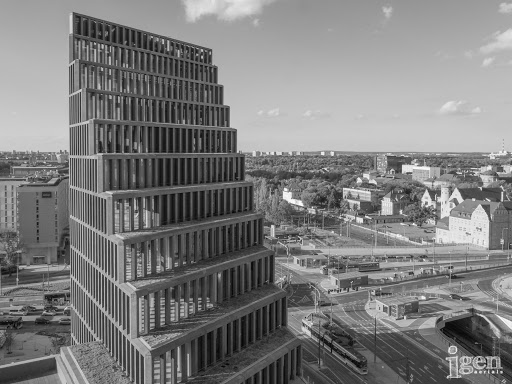

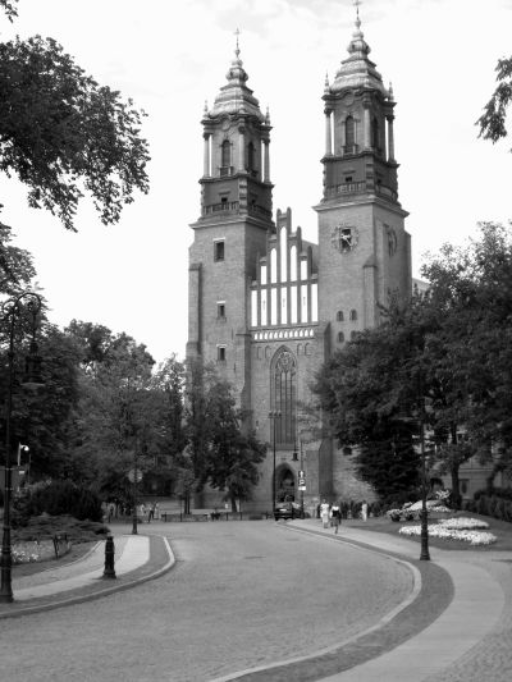

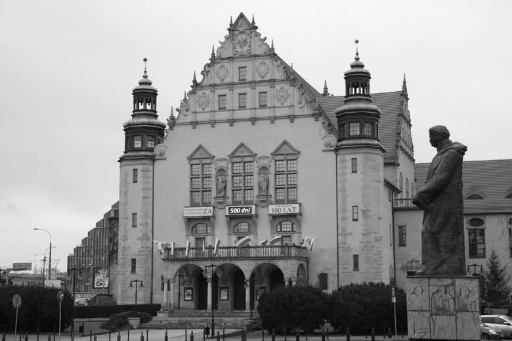

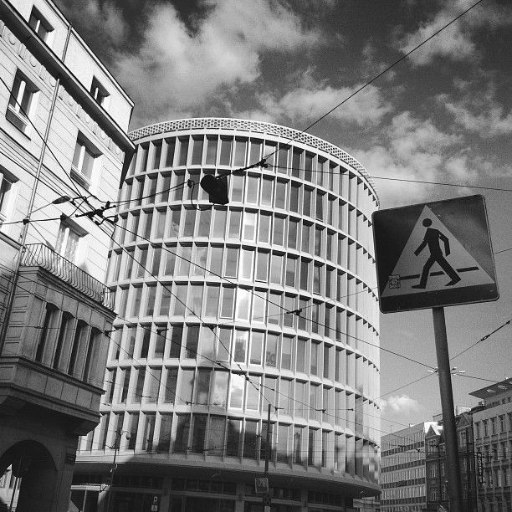

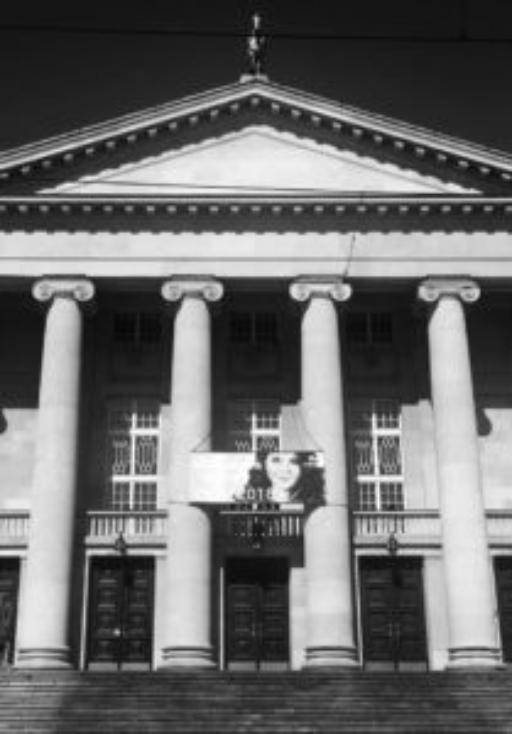

In [0]:
# show one image per class
for i, class_dir in enumerate(os.listdir(path_to_dataset)):
  #print("i = {}, class_dir = {}".format(i,class_dir))
  path_to_dir = os.path.join(path_to_dataset, class_dir)
  for filename in os.listdir(path_to_dir):
    path_to_file = os.path.join(path_to_dir,filename)
    img = cv.imread(path_to_file, 0)
    # scale but retain height - width ratio
    hw_ratio = img.shape[0]/img.shape[1]
    img_reshaped = cv.resize(img, ((512,int(512*hw_ratio))))
    gc.cv2_imshow(img_reshaped)
    break

## 2) Feature detection

In [6]:
fdd = cv.AKAZE_create()

def create_keypoints_data(X, descriptor):
  X_keypoints = []
  x = 0 
  for img in X:
    keypoints, descriptors = descriptor.detectAndCompute(img, None)
    X_keypoints.extend(descriptors)
  return X_keypoints

X_keypoints = create_keypoints_data(X_train, fdd)
X_keypoints = np.asarray(X_keypoints) 
print("We have {} keypoints and each of them consist of {} fields".format(X_keypoints.shape[0], X_keypoints.shape[1]))


We have 1208070 keypoints and each of them consist of 61 fields


Example picture after feature detection and description.

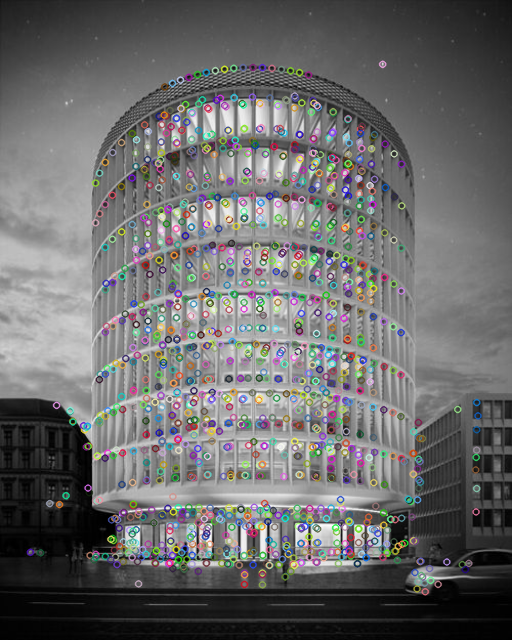

In [0]:
kp,desc = fdd.detectAndCompute(X_train[0], None)
kp_img = np.copy(X_train[0])
kp_img = cv.drawKeypoints(X_train[0], kp, kp_img) 
gc.cv2_imshow(kp_img)

## 3) Create dictionary

Group similar keypoint in groups with k nearest neighbors algorithm. 

In [0]:
NB_Words = 40
def create_bow(no_words, X):
  vocab_model = KMeans(n_clusters=no_words, random_state=42, n_jobs=-1)
  vocab_model.fit(X)
  return vocab_model

kmean = create_bow(NB_Words, X_keypoints)
print(kmean.labels_)

## 4) Create histograms

Decide to which group ("word") keypoint belongs to. Create histogram - how much words occure on each image. Scale histogram at the end. 

In [0]:
def features2histogram(descriptors, vocab_model):
  histo = np.zeros(vocab_model.n_clusters, dtype=np.float32)

  suma = 0.0
  #count occurence          
  for desc in descriptors:
    word_index = vocab_model.predict([desc])[0]
    histo[word_index] += 1.0
    suma += 1.0

  # scale 
  histo = histo/suma*100.0

  return histo

Example histogram

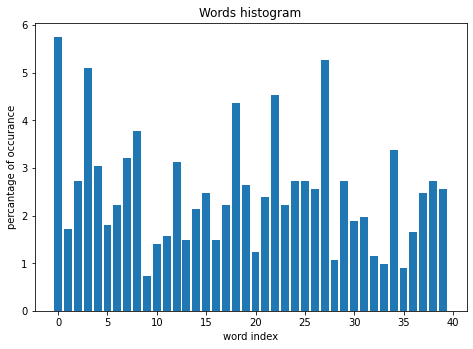

In [0]:
for img in X_train:
  keypoints, descriptors = fdd.detectAndCompute(img, None)
  histo = features2histogram(descriptors, kmean)
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])
  ax.bar(range(NB_Words), histo)
  plt.title("Words histogram")
  plt.xlabel("word index")
  plt.ylabel("percantage of occurance")
  plt.show()
  break

## 5) Transform dataset

Transform our image dataset into histogram dataset

In [0]:
def apply_feature_transform(X, feature_detector_descriptor, vocab_model):
  X_transformed = []
  for im in X:
    kp, des = feature_detector_descriptor.detectAndCompute(im,None)
    X_transformed.append(features2histogram(des, vocab_model))
  return np.asarray(X_transformed)

X_train_trans = apply_feature_transform(X_train,fdd, kmean)
X_test_trans = apply_feature_transform(X_test,fdd, kmean)
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(X_train_trans)
X_train_trans = min_max_scaler.transform(X_train_trans)
X_test_trans = min_max_scaler.transform(X_test_trans)

## 6) Train 

Create functions to search for best parameters of algorithms with GridSearch.

In [0]:
def search_for_best_random_forest(X_train, y_train):
  # grid search random tree forest
  n_estimators = [10, 100, 500, 1000]
  max_depth = [5, 10, 25, 50]
  # Minimum number of samples required to split a node
  min_samples_split = [2, 5, 10]
  hyperF = dict(n_estimators = n_estimators, max_depth = max_depth, min_samples_split = min_samples_split)
  rnd = RandomForestClassifier(random_state=42)
  clf = GridSearchCV(rnd, hyperF, scoring='accuracy', n_jobs=-1)
  clf.fit(X_train, y_train)
  bestForest = clf.best_estimator_
  return bestForest

def search_for_best_SVC(X_train, y_train):
  param_grid = [
    {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
    {'C': [1, 10, 100, 1000], 'gamma': [0.01, 0.001, 0.0001], 'kernel': ['rbf']},
  ]
  svc = SVC(random_state=42)
  clf = GridSearchCV(svc, param_grid, scoring='accuracy', n_jobs=-1)
  clf.fit(X_train, y_train)
  bestSVC = clf.best_estimator_
  return bestSVC

def search_for_best_tree(X_train, y_train):
    parameters = {'min_samples_split': range(10, 500, 20), 'max_depth': range(1, 20, 2)}
    clf_tree = tree.DecisionTreeClassifier(random_state=42)
    clf = GridSearchCV(clf_tree, parameters)
    clf.fit(X_train, y_train)
    bestTree = clf.best_estimator_
    return bestTree


def test_clf(best, X_train, y_train, X_test, y_test):
    y_predict = best.predict(X_train)
    acc = accuracy_score(y_train, y_predict)
    conf = confusion_matrix(y_train, y_predict)
    print('It is {0}'.format(best))
    print("it's train accuracy is {0}. Confusion matrix:\n{1}".format(acc, conf))
    y_predict = best.predict(X_test)
    acc = accuracy_score(y_test, y_predict)
    conf = confusion_matrix(y_test, y_predict)
    print("it's test accuracy is {0}. Confusion matrix:\n{1}".format(acc, conf))



There are diffrent featueres descriptors. Try which one of them works the best in this case. 

AKAZE performs best

In [0]:
fdd_akaze = cv.AKAZE_create()
fdd_brisk = cv.BRISK_create()
fdd_orb = cv.ORB_create()

descriptors = [fdd_akaze]

Search for best classifiers using Grid Search algorithm.

In [0]:
best_forests = dict()
best_svcs = dict()
# check for every descripor
for desc in descriptors:
  X_keypoints = create_keypoints_data(X_train, desc)
  fdd = desc
  # check for following number of words in dictionary
  for n in [40]:
      kmean = create_bow(n, X_keypoints)
      X_train_trans = apply_feature_transform(X_train,fdd, kmean)
      X_test_trans = apply_feature_transform(X_test,fdd, kmean)
      min_max_scaler = MinMaxScaler()
      min_max_scaler.fit(X_train_trans)
      X_train_trans = min_max_scaler.transform(X_train_trans)
      X_test_trans = min_max_scaler.transform(X_test_trans)

      best = search_for_best_random_forest(X_train_trans, y_train)
      best_forests[n]=best
      test_clf(best, X_train_trans, y_train, X_test_trans, y_test)

      best = search_for_best_SVC(X_train_trans, y_train)
      best_svcs[n]=best
      test_clf(best, X_train_trans, y_train, X_test_trans, y_test)

      best = search_for_best_tree(X_train_trans, y_train)
      best_tree[n] = best
      test_clf(best, X_train_trans, y_train, X_test_trans, y_test)


with open('/content/drive/My Drive/BoW_project/bestForest', 'wb') as f:
  pickle.dump(best_forests, f)

with open('/content/drive/My Drive/BoW_project/bestSVCs', 'wb') as f:
  pickle.dump(best_svcs, f)
    

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


best Random forest for 40 words.
 it's accuracy is 0.76. Confusion matrix:
[[4 0 0 0 1]
 [0 4 0 0 1]
 [0 0 5 0 0]
 [1 0 2 2 0]
 [0 0 0 1 4]]
best SVM for 40 words.
 it's accuracy is 0.72. Confusion matrix:
[[3 0 0 0 2]
 [0 3 0 1 1]
 [0 0 5 0 0]
 [1 0 1 2 1]
 [0 0 0 0 5]]


## 7) Sum up

Load saved dataset and classifiers. Show results

It is RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=25, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
it's train accuracy is 0.9773706896551724. Confusion matrix:
[[165   0   0   8   0]
 [  0 197   0   0   8]
 [  0   0 164   0   0]
 [  3   0   0 178   0]
 [  0   2   0   0 203]]
it's test accuracy is 0.88. Confusion matrix:
[[5 0 0 0 0]
 [0 5 0 0 0]
 [0 0 5 0 0]
 [0 0 2 3 0]
 [0 1 0 0 4]]


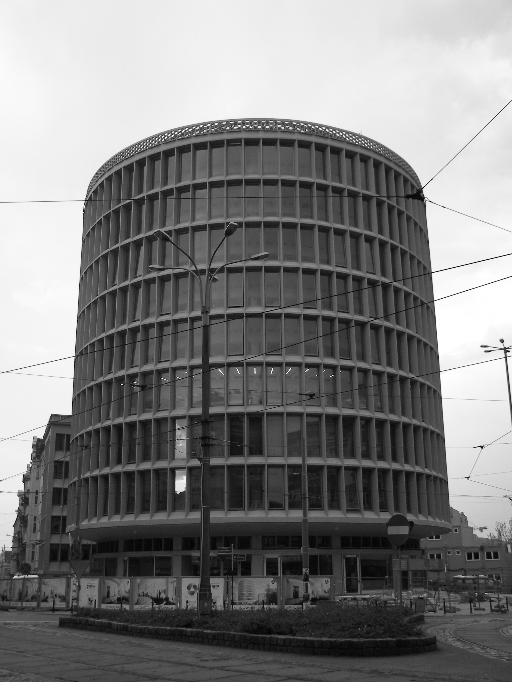

okraglak


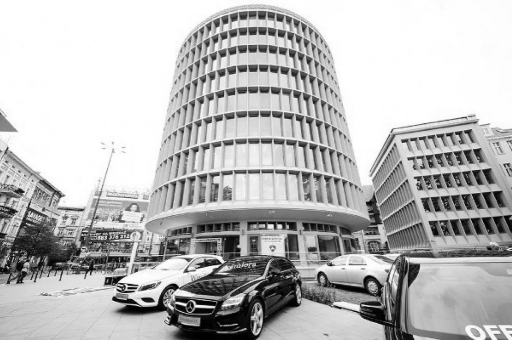

okraglak


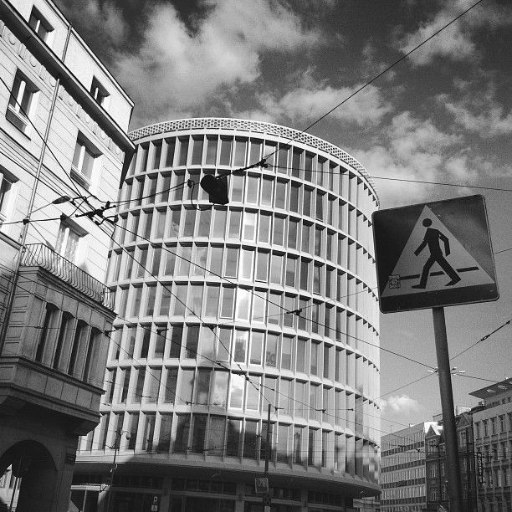

okraglak


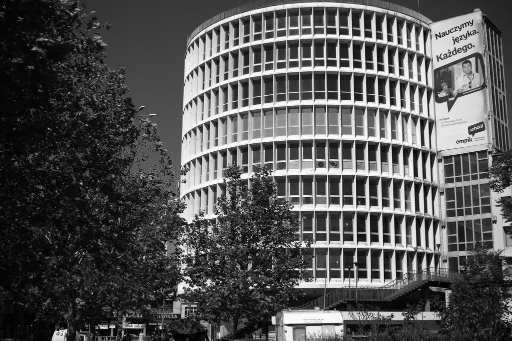

okraglak


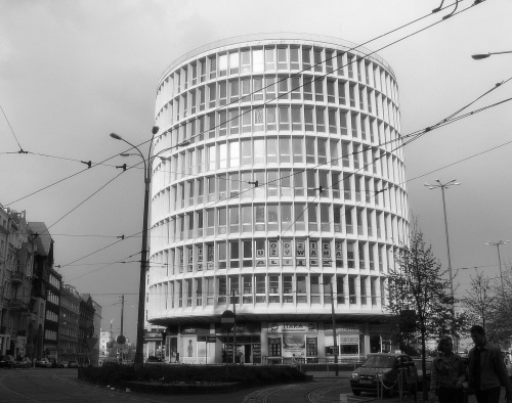

okraglak


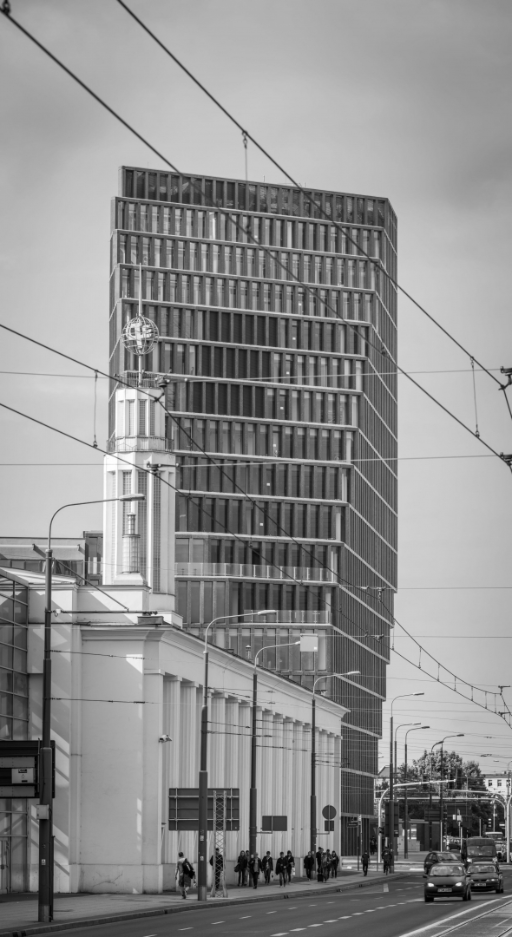

okraglak


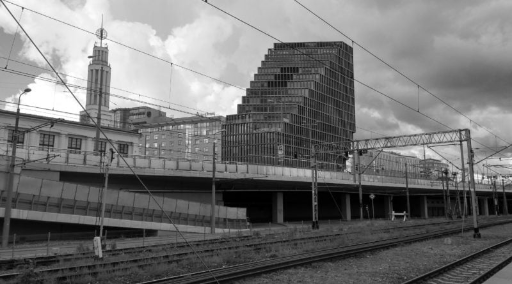

baltyk


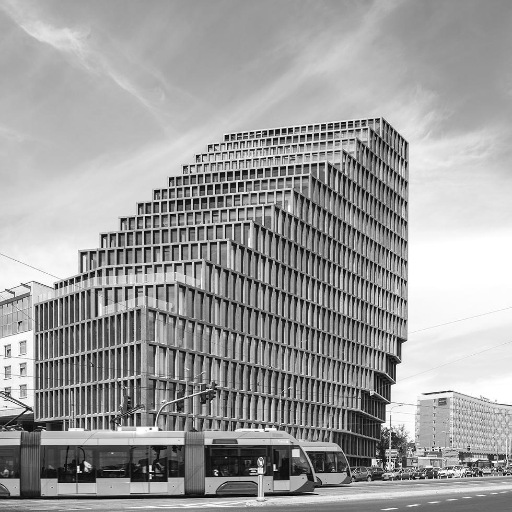

okraglak


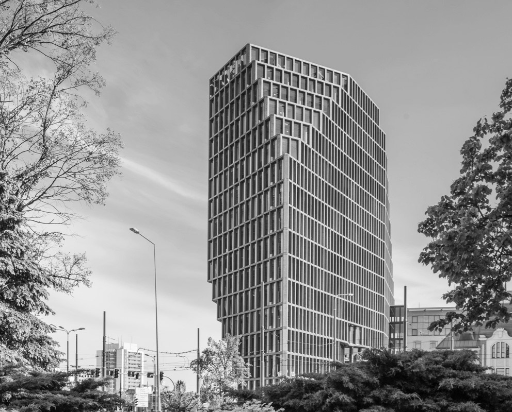

baltyk


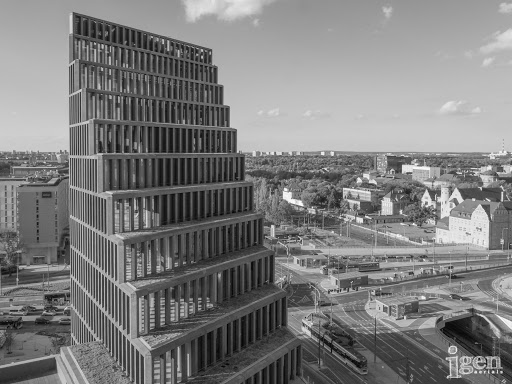

baltyk


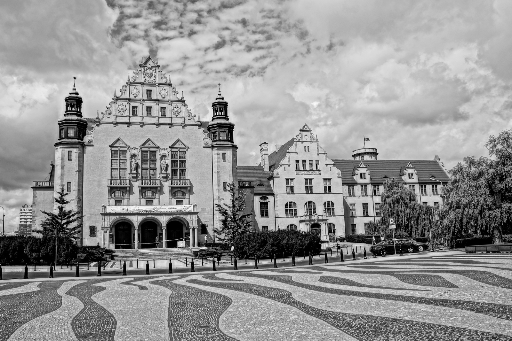

uam


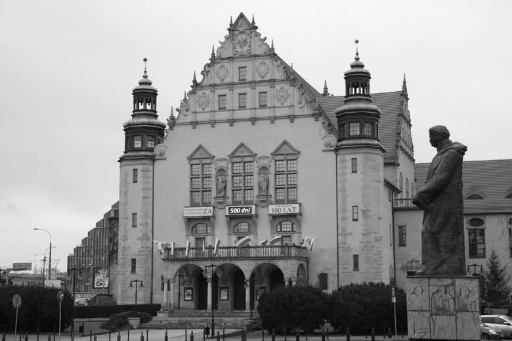

uam


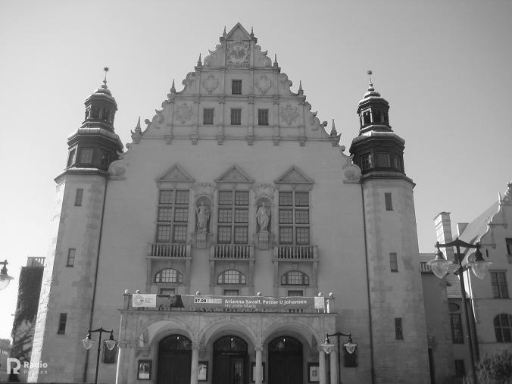

uam


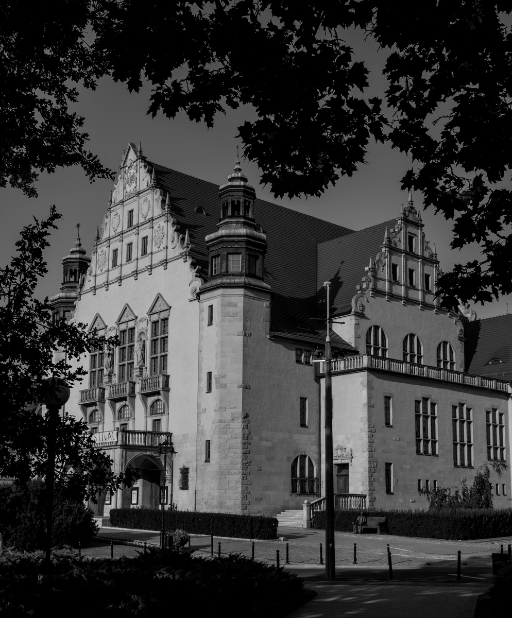

uam


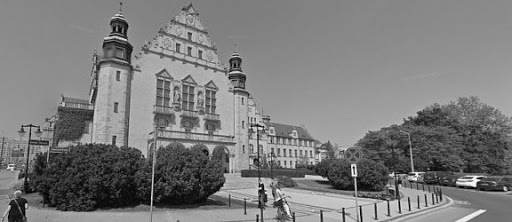

uam


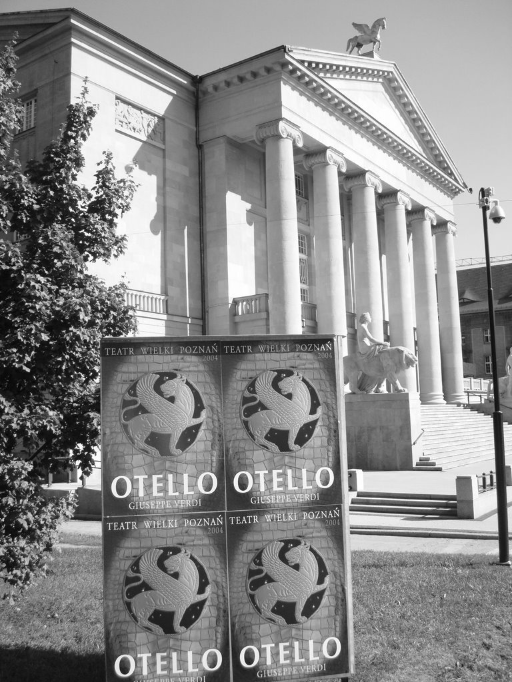

teatr_wielki


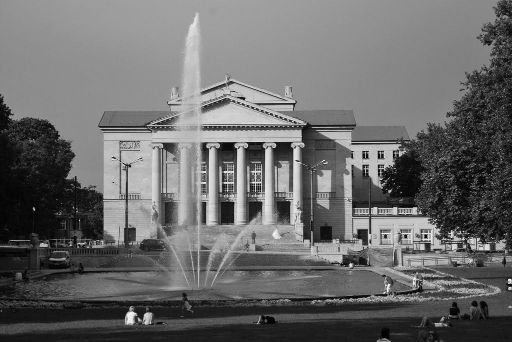

teatr_wielki


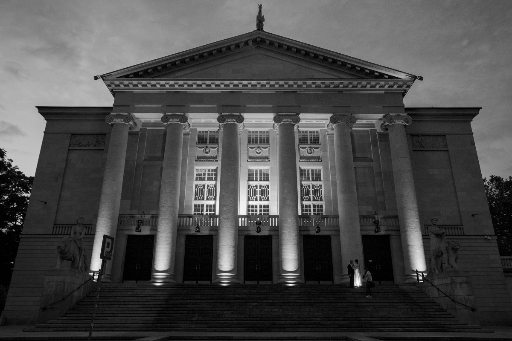

teatr_wielki


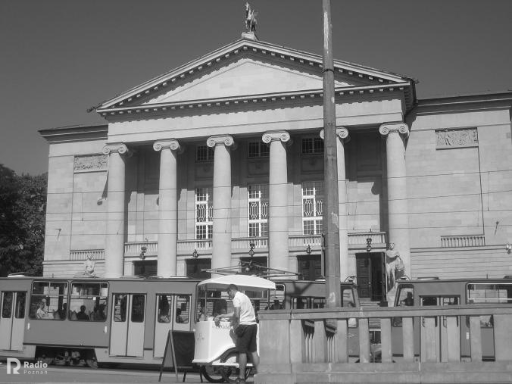

teatr_wielki


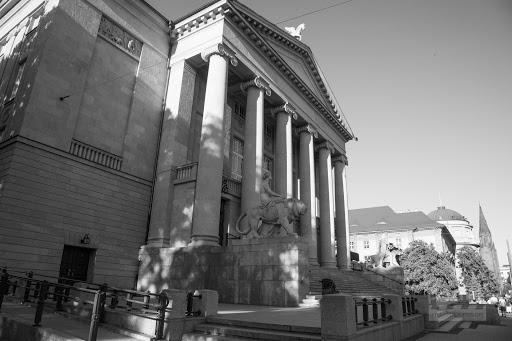

teatr_wielki


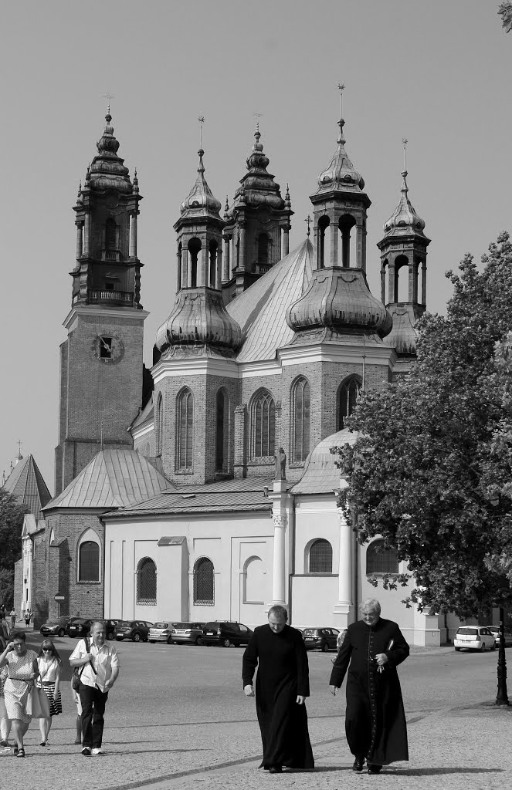

katedra


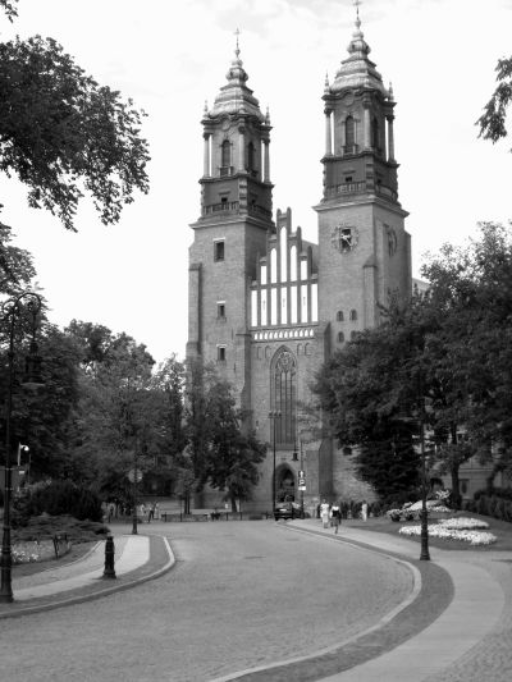

katedra


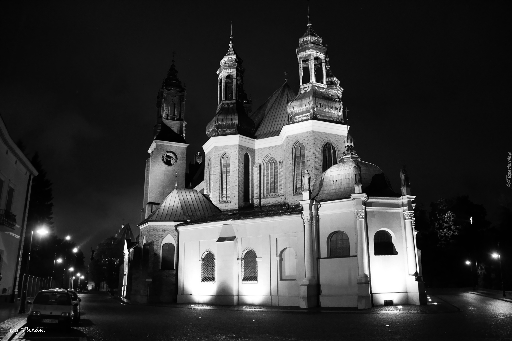

teatr_wielki


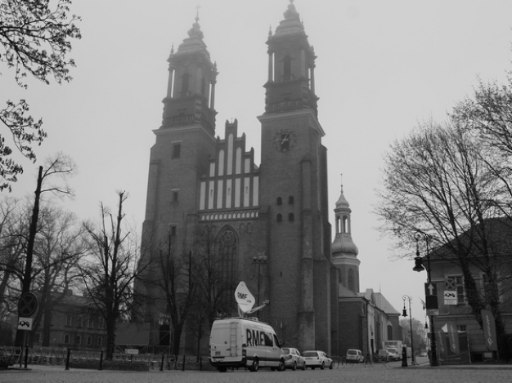

katedra


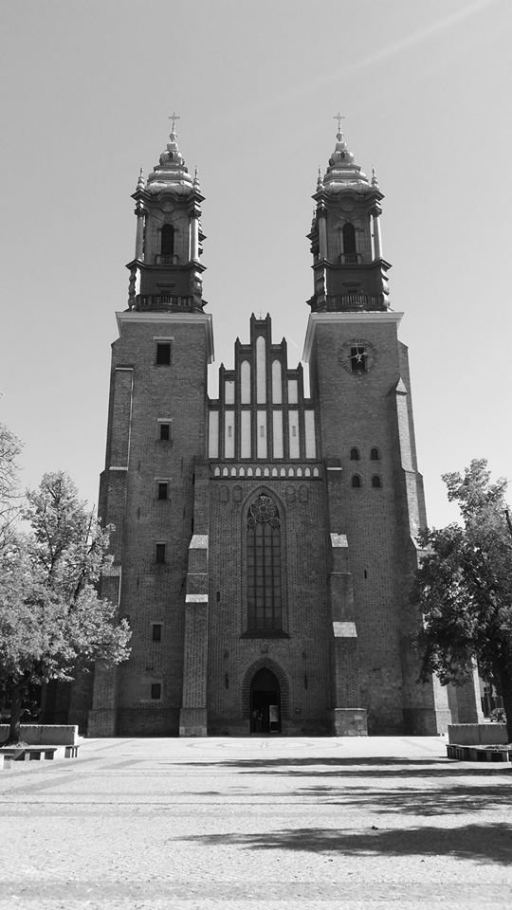

katedra


In [25]:
# path to saved calssifiers

path_to_clf = '/content/drive/My Drive/BoW_project/Forest88/bestForest2'
with open(path_to_clf, 'rb') as f:
  clf = pickle.load(f)

path_to_kmean = '/content/drive/My Drive/BoW_project/Forest88/kmean'
with open(path_to_kmean, 'rb') as f:
  kmean = pickle.load(f)

path_to_xtrain = '/content/drive/My Drive/BoW_project/Forest88/xtrain'
with open(path_to_xtrain, 'rb') as f:
  X_train = pickle.load(f)

path_to_ytrain = '/content/drive/My Drive/BoW_project/Forest88/ytrain'
with open(path_to_ytrain, 'rb') as f:
  y_train = pickle.load(f)
  

X_train_trans = apply_feature_transform(X_train,fdd, kmean)
X_test_trans = apply_feature_transform(X_test,fdd, kmean)
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(X_train_trans)
X_train_trans = min_max_scaler.transform(X_train_trans)
X_test_trans = min_max_scaler.transform(X_test_trans)

test_clf(clf, X_train_trans, y_train, X_test_trans, y_test)

for img in X_test:
  x = apply_feature_transform([img], fdd, kmean)
  x = min_max_scaler.transform(x)
  y_predict = clf.predict(x)
  gc.cv2_imshow(img)
  print(y_labels[y_predict[0]])

In [0]:
path_to_clf = '/content/drive/My Drive/BoW_project/wyniki/Forest88/bestForest2'
with open(path_to_clf, 'wb') as f:
  pickle.dump(clf, f)

path_to_kmean = '/content/drive/My Drive/BoW_project/wyniki/Forest88/kmean'
with open(path_to_kmean, 'wb') as f:
  pickle.dump(kmean, f)

path_to_xtrain = '/content/drive/My Drive/BoW_project/wyniki/Forest88/xtrain'
with open(path_to_xtrain, 'wb') as f:
  pickle.dump(X_train, f)

path_to_ytrain = '/content/drive/My Drive/BoW_project/wyniki/Forest88/ytrain'
with open(path_to_ytrain, 'wb') as f:
  pickle.dump(y_train, f)

